<a href="https://colab.research.google.com/github/Untick/Selector_ObjDet/blob/DmitryGribkov-folder/Selector_Final_codes_20230701.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [174]:
#Конечная структура модели будет следующей:

#Входной слой (input_img): Слой, принимающий входные изображения размером 32x32x3.

#Кодировщик (Encoder):
#Сверточный слой (conv1): 32 фильтра размером 3x3, функция активации ReLU, заполнение "same" для сохранения размеров.
#Пулинг слой (pool1): Пулинг размером 2x2.
#Сверточный слой (conv2): 64 фильтра размером 3x3, функция активации ReLU, заполнение "same".
#Пулинг слой (pool2): Пулинг размером 2x2.
#Сверточный слой (conv3): 128 фильтров размером 3x3, функция активации ReLU, заполнение "same".
#Пулинг слой (pool3): Пулинг размером 2x2.
#Плоский слой (flat): Преобразование трехмерного тензора в одномерный вектор.
#Входной слой для меток классов (class_label): Слой, принимающий метки классов для конкатенации с выходом плоского слоя.
#Конкатенация (concat): Объединение плоского слоя и входного слоя меток классов.
#Полносвязный слой (encoded): 256 нейронов с функцией активации ReLU для получения закодированных представлений.

#Декодировщик (Decoder):
#Полносвязный слой (x): 128 нейронов с функцией активации ReLU для получения промежуточных представлений.
#Изменение формы (x): Преобразование одномерного вектора в трехмерный тензор размером 4x4x8.
#Сверточный слой (x): 128 фильтров размером 3x3, функция активации ReLU, заполнение "same".
#Повышающий дискретизирующий слой (x): Увеличение размеров в два раза.
#Сверточный слой (x): 64 фильтра размером 3x3, функция активации ReLU, заполнение "same".
#Повышающий дискретизирующий слой (x): Увеличение размеров в два раза.
#Сверточный слой (x): 32 фильтра размером 3x3, функция активации ReLU, заполнение "same".
#Повышающий дискретизирующий слой (x): Увеличение размеров в два раза.
#Сверточный слой (x): 3 фильтра размером 3x3, функция активации сигмоид, заполнение "same".
#Выходной слой (decoded): Реконструированные изображения размером 32x32x3.

#Автокодировщик (Autoencoder): Модель, объединяющая входной слой, кодировщик и декодировщик.

#Компиляция модели: Автокодировщик компилируется с оптимизатором "adam" и функцией потерь "mse" (среднеквадратичная ошибка).

#Обучение модели: Автокодировщик обучается на обучающих данных с использованием входных изображений и категориальных меток классов в качестве входных данных и реконструированных изображений в качестве целевых данных.

#Извлечение вложений изображений: Используя обученный кодировщик, извлекаются вложения изображений путем предсказания кодированных представлений на входных изображениях.

#Построение и обучение модели ближайших соседей: Модель ближайших соседей строится и обучается на извлеченных вложениях изображений.





Downloading...
From: https://drive.google.com/uc?id=1ZdQ1dAGWOL8lTK73MQV1UQf-2S8BKcTq
To: /content/processed_extended_dataset.zip
100%|██████████| 76.6M/76.6M [00:00<00:00, 261MB/s]


Epoch 1/1000
165/165 [==============================] - 6s 11ms/step - loss: 0.0415 - val_loss: 0.0182
Epoch 2/1000
165/165 [==============================] - 1s 8ms/step - loss: 0.0158 - val_loss: 0.0140
Epoch 3/1000
165/165 [==============================] - 1s 8ms/step - loss: 0.0126 - val_loss: 0.0110
Epoch 4/1000
165/165 [==============================] - 1s 8ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 5/1000
165/165 [==============================] - 1s 8ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 6/1000
165/165 [==============================] - 1s 8ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 7/1000
165/165 [==============================] - 1s 8ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 8/1000
165/165 [==============================] - 2s 10ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 9/1000
165/165 [==============================] - 2s 11ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 10/1000
165/165 [==============================] - 1s 8ms/step - loss: 0.

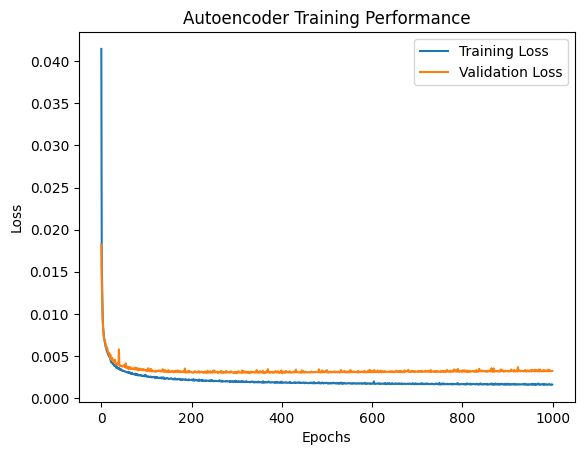

83/83 [==============================] - 0s 2ms/step
Training Reconstruction Error: 1.98%
Test Reconstruction Error: 2.57%


In [175]:

import os
import gdown
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors

# Set random seed for reproducibility
np.random.seed(42)

# Set TensorFlow random seed for reproducibility
tf.random.set_seed(42)

# Ссылка для скачивания архивного файла с датасетом
dataset_url = 'https://drive.google.com/uc?id=1ZdQ1dAGWOL8lTK73MQV1UQf-2S8BKcTq'

# Путь для сохранения архивного файла
zip_file_path = 'processed_extended_dataset.zip'

# Скачивание архивного файла
gdown.download(dataset_url, zip_file_path, quiet=False)

# Распаковка архивного файла
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Удаление архивного файла
os.remove(zip_file_path)

# Путь к распакованному датасету
dataset_path = 'dataset'

# Получение списка классов из директорий датасета
class_list = sorted(os.listdir(dataset_path))
num_classes = len(class_list)

# Создание пустых массивов для изображений и меток классов
image_array = []
data_labels = []

# Загрузка изображений и создание массива данных
for class_label, class_name in enumerate(class_list):
    class_dir = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_dir)
    num_images = len(image_files)

    for i in range(num_images):
        image_path = os.path.join(class_dir, image_files[i])
        try:
            image = Image.open(image_path).convert("RGB")
            image = image.resize((64, 64))
            image_array.append(np.array(image))
            data_labels.append(class_label)
        except Exception as e:
            print(f'Ошибка при обработке изображения {image_path}: {str(e)}')

image_array = np.array(image_array)
data_labels = np.array(data_labels)

# Разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(image_array, data_labels, test_size=0.2, stratify=data_labels, random_state=42)

# Преобразование меток классов в one-hot encoding
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

# Изменение размера обучающих и тестовых изображений на 32x32
x_train_resized = np.array([np.array(Image.fromarray(img).resize((32, 32))) for img in x_train])
x_test_resized = np.array([np.array(Image.fromarray(img).resize((32, 32))) for img in x_test])

# Преобразование значений пикселей в диапазон [0, 1]
x_train_resized = x_train_resized.astype('float32') / 255.
x_test_resized = x_test_resized.astype('float32') / 255.

# Encoder layers
input_img = Input(shape=(32, 32, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
pool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D((2, 2))(conv3)
flat = Flatten()(pool3)
class_label = Input(shape=(num_classes,))
concat = concatenate([flat, class_label])
encoded = Dense(256, activation='relu')(concat)

# Decoder layers
x = Dense(128, activation='relu')(encoded)
x = Reshape((4, 4, 8))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded = x

# Define the autoencoder model
autoencoder = Model([input_img, class_label], decoded)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder model
history = autoencoder.fit([x_train_resized, y_train_cat], x_train_resized, epochs=1000, batch_size=64, validation_data=([x_test_resized, y_test_cat], x_test_resized))

# Extract image embeddings using the trained encoder
encoder = Model([input_img, class_label], encoded)

# Изменение размера изображений на 32x32 для извлечения векторных представлений
resized_images = np.array([np.array(Image.fromarray(img).resize((32, 32))) for img in image_array])
image_embeddings = encoder.predict([resized_images, keras.utils.to_categorical(data_labels, num_classes)])

# Build and train the nearest neighbors model
neighbors_model = NearestNeighbors(n_neighbors=5, algorithm='auto')
neighbors_model.fit(image_embeddings)

# Plot training performance
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate reconstruction error as percentage
x_train_predicted = autoencoder.predict([x_train_resized, y_train_cat])
train_reconstruction_error = np.mean(np.abs(x_train_predicted - x_train_resized)) * 100

x_test_predicted = autoencoder.predict([x_test_resized, y_test_cat])
test_reconstruction_error = np.mean(np.abs(x_test_predicted - x_test_resized)) * 100

print(f'Training Reconstruction Error: {train_reconstruction_error:.2f}%')
print(f'Test Reconstruction Error: {test_reconstruction_error:.2f}%')


In [ ]:

#epochs=100, batch_size=64
#Training Reconstruction Error: 2.56%
#Test Reconstruction Error: 2.78%

#epochs=1000, batch_size=64
#Training Reconstruction Error: 1.98%
#Test Reconstruction Error: 2.57%




In [176]:
import matplotlib.pyplot as plt
import random

def show_images_per_class(images_train, labels_train, images_test, labels_test, class_list):
    num_classes = len(class_list)
    num_images_per_class = 15

    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(20, 20))
    plt.subplots_adjust(hspace=0.8, wspace=0.5)  # Adjust the vertical and horizontal spacing between subplots

    # Define a list of colors for class name labels
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'teal', 'pink', 'gray', 'olive']

    for class_label, class_name in enumerate(class_list):
        # Display one image from the training set
        train_indices = np.where(labels_train == class_label)[0][:1]
        ax = axes[class_label, 0]
        ax.axis('off')
        ax.imshow(images_train[train_indices[0]])
        ax.set_title('Обучение', fontsize=10, fontweight='bold')

        # Add class name label above the row of image labels
        color = random.choice(colors)  # Select a random color from the list
        axes[class_label, 0].text(0.5, -9.35, class_name, ha='center', va='bottom', fontsize=12, fontweight='bold',
                                  color=color)

        # Display the rest of the images from the testing set
        test_indices = np.where(labels_test == class_label)[0][:num_images_per_class - 1]

        for i, idx in enumerate(test_indices):
            ax = axes[class_label, i + 1]
            ax.axis('off')
            ax.imshow(images_test[idx])
            ax.set_title(f'Тест {i + 1}', fontsize=8, fontweight='bold')
    plt.show()


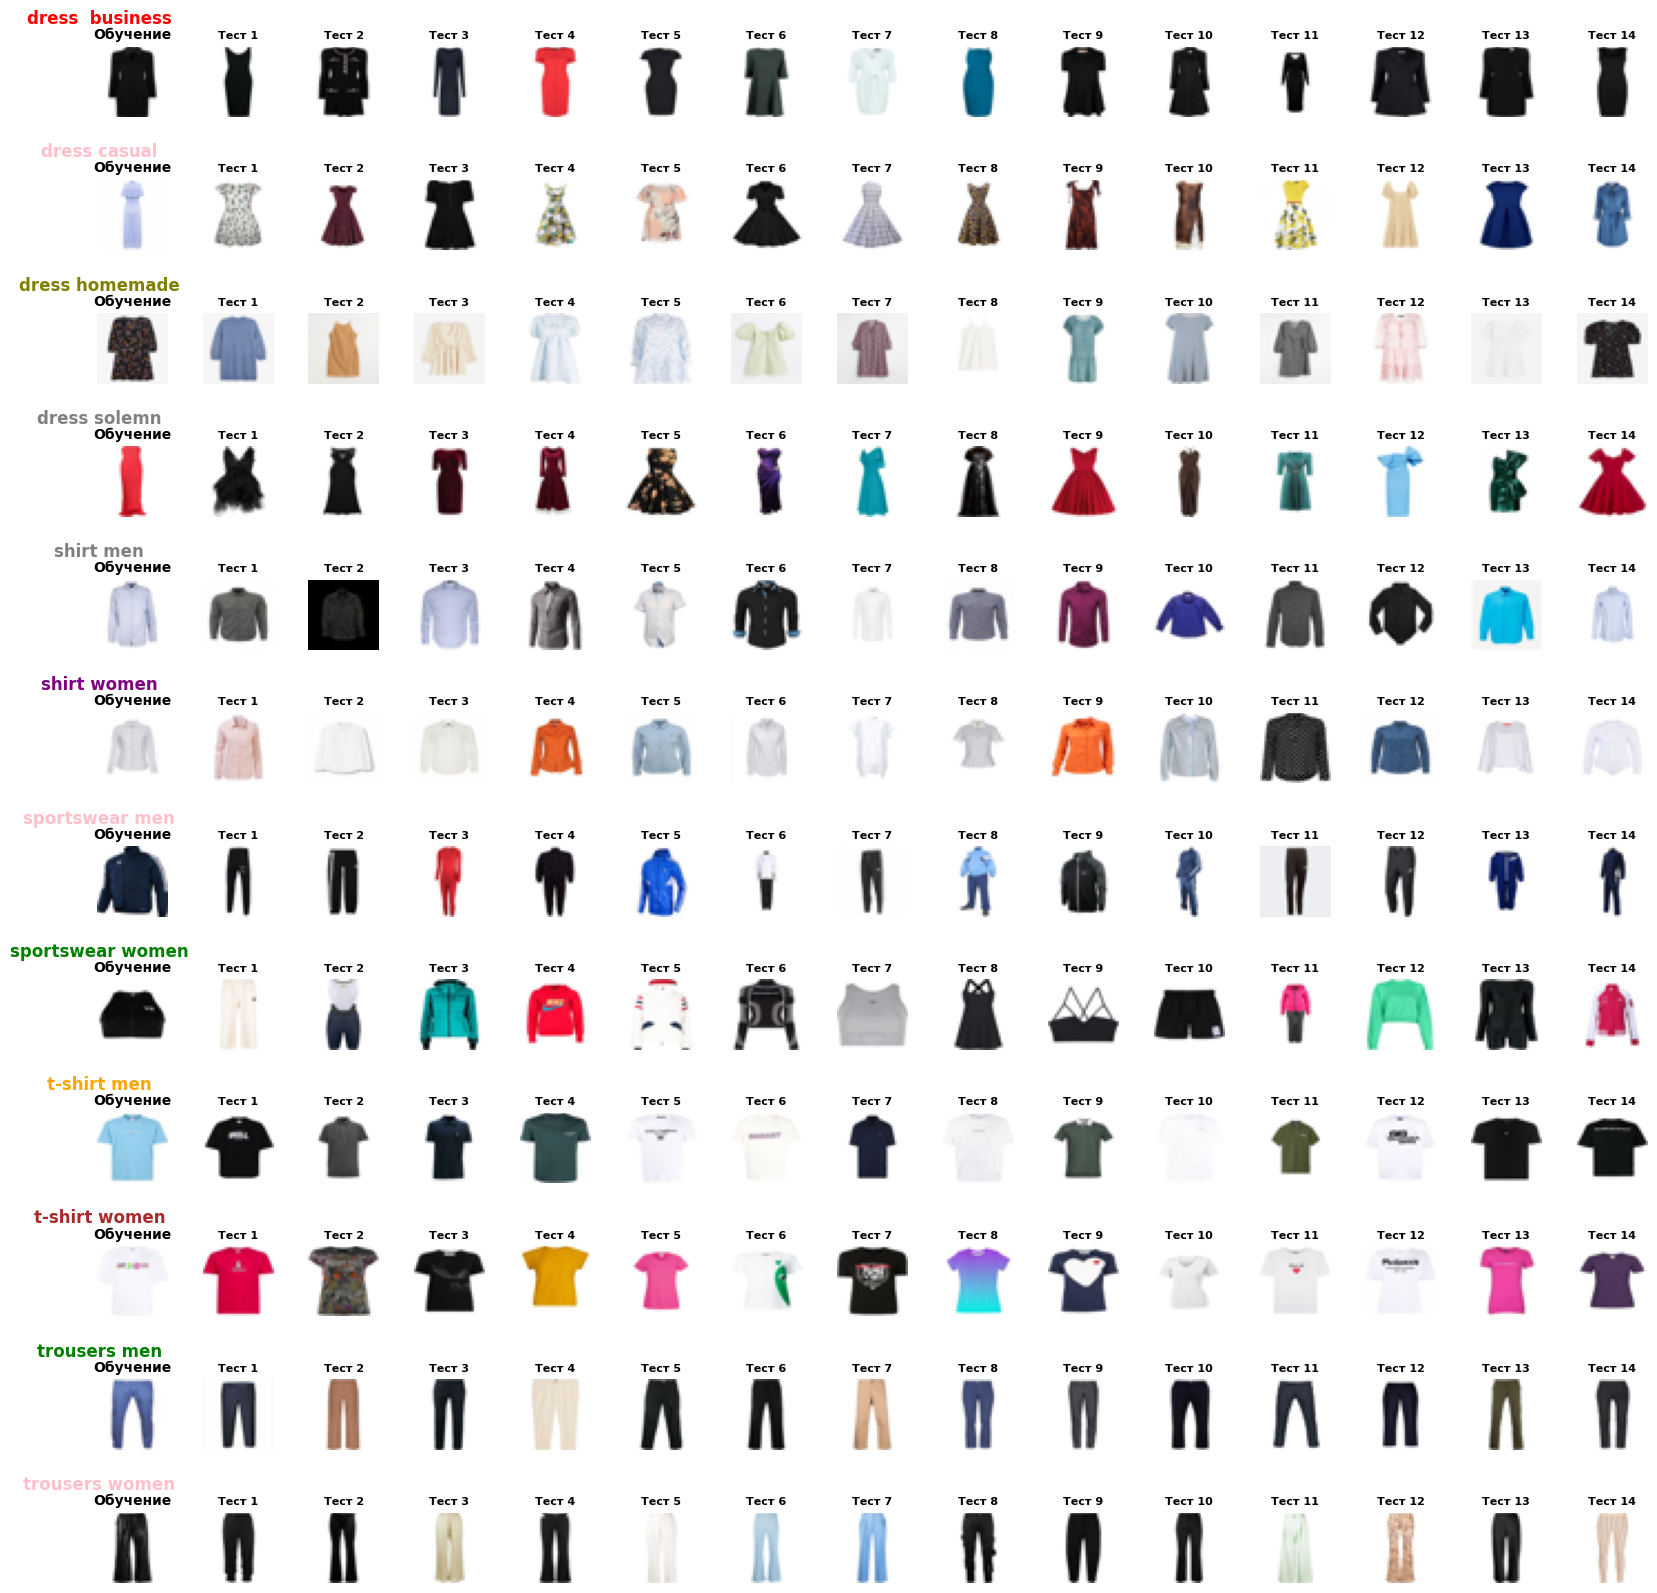

In [177]:
# Display images per class for the training and testing datasets
show_images_per_class(x_train_resized, y_train, x_test_resized, y_test, class_list)
